<a href="https://colab.research.google.com/github/RizalRio/py-crop-recommendation-anfis/blob/main/CropRecommendation_NeuroFuzzy_UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sistem Rekomendasi Tanaman Berbasis Hybrid Neuro-Fuzzy**
**Mata Kuliah:** Logika Fuzzy,
**Metode:** Hybrid Neuro-Fuzzy (Gaussian MF + MLP Neural Network)

---
### **1. Pendahuluan & Persiapan**
Pada tahap ini, kita menyiapkan lingkungan kerja (*environment*) dengan menginstall library `scikit-fuzzy` yang diperlukan untuk logika fuzzy. Kita juga memuat dataset pertanian yang berisi 7 variabel lingkungan (N, P, K, Suhu, Kelembaban, pH, Curah Hujan).

In [ ]:
# ==========================================
# BAGIAN 1: INSTALL LIBRARY & LOAD DATA
# ==========================================

# 1. Install Library scikit-fuzzy (Wajib di Colab)
!pip install -U scikit-fuzzy

# 2. Import Library
import pandas as pd
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# 3. Load Dataset
try:
    df = pd.read_csv('Crop_recommendation.csv')
    print("✅ Dataset berhasil dimuat!")
    print(f"   Jumlah Data: {df.shape[0]} baris")
    print(f"   Jumlah Fitur: {df.shape[1]} kolom")
except:
    print("❌ Eror: File 'Crop_recommendation.csv' belum diupload!")

✅ Dataset berhasil dimuat!
   Jumlah Data: 2200 baris
   Jumlah Fitur: 8 kolom


### **2. Preprocessing: Fuzzifikasi Gaussian (Adaptive)**
Sistem ini menggunakan pendekatan **Hybrid**. Sebelum data dipelajari oleh AI, data mentah (*Crisp Input*) diubah menjadi **Vektor Fuzzy**.

Kami menggunakan **Gaussian Membership Function (Kurva Lonceng)** karena kemampuannya menangani ketidakpastian data alam dengan transisi yang lebih halus dibandingkan kurva segitiga. Batas fuzzy (Rendah/Sedang/Tinggi) ditentukan secara otomatis berdasarkan statistik (Mean & Standar Deviasi) dari setiap kolom data.

In [ ]:
# ==========================================
# BAGIAN 2: FUZZIFICATION LAYER (Gaussian)
# ==========================================

def get_gaussian_fuzzy_data(df, cols):
    """
    Mengubah data numerik menjadi data fuzzy menggunakan kurva Gaussian.
    Gaussian lebih 'alami' dibanding segitiga karena transisinya mulus.
    """
    fuzzy_store = []
    feature_names = []

    print("⚙️ Sedang melakukan Fuzzifikasi data (Angka -> Logika Fuzzy)...")

    for col in cols:
        data = df[col].values

        # Hitung Statistik Data
        mean = np.mean(data)
        sigma = np.std(data)
        d_min, d_max = data.min(), data.max()

        # Buat Universe (Rentang Data)
        universe = np.linspace(d_min, d_max, 100)

        # Definisi Kurva Gaussian (Lonceng)
        # Low: Fokus di nilai minimum
        mf_low = fuzz.gaussmf(universe, d_min, sigma/2)
        # Med: Fokus di rata-rata (mean)
        mf_med = fuzz.gaussmf(universe, mean, sigma/2)
        # High: Fokus di nilai maksimum
        mf_high = fuzz.gaussmf(universe, d_max, sigma/2)

        # Transformasi Data ke Nilai Fuzzy (0.0 - 1.0)
        col_vals = []
        for val in data:
            col_vals.append([
                fuzz.interp_membership(universe, mf_low, val),
                fuzz.interp_membership(universe, mf_med, val),
                fuzz.interp_membership(universe, mf_high, val)
            ])
        fuzzy_store.append(np.array(col_vals))

        # Simpan nama fitur untuk keperluan aturan nanti
        feature_names.extend([f'{col}_Rendah', f'{col}_Sedang', f'{col}_Tinggi'])

    # Gabungkan semua hasil transformasi
    return np.hstack(fuzzy_store), feature_names

# --- EKSEKUSI ---
# Kita pakai SEMUA 7 variabel agar akurasi maksimal (Sesuai strategi kita)
target_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X_fuzzy, fuzzy_feat_names = get_gaussian_fuzzy_data(df, target_cols)
y = df['label']

print(f"✅ Fuzzifikasi Selesai! Dimensi Data Baru: {X_fuzzy.shape}")

⚙️ Sedang melakukan Fuzzifikasi data (Angka -> Logika Fuzzy)...
✅ Fuzzifikasi Selesai! Dimensi Data Baru: (2200, 21)


### **3. Training Model: Neural Network (MLP)**
Data yang telah difuzzifikasi kemudian dilatih menggunakan **Multi-Layer Perceptron (MLP)**.
Untuk mendapatkan akurasi terbaik, kami menerapkan **Auto-Tuning** menggunakan `GridSearchCV`. Algoritma ini akan mencari kombinasi *Hyperparameters* (jumlah neuron, kecepatan belajar, iterasi) yang paling optimal untuk dataset ini.

In [ ]:
# ==========================================
# BAGIAN 3: TRAINING AI (Neural Network)
# ==========================================

# 1. Split Data
X_train, X_test, y_train, y_test = train_test_split(X_fuzzy, y, test_size=0.2, random_state=42)

# 2. Setup Neural Network & GridSearch
print("\n🧠 Sedang melatih Neural Network dengan Auto-Tuning...")
print("(Proses ini mencari konfigurasi terbaik, mohon tunggu sebentar...)")

# Parameter yang akan diuji coba oleh komputer
param_grid = {
    'hidden_layer_sizes': [(32, 16), (64, 32), (50, 50)], # Coba berbagai ukuran otak
    'learning_rate_init': [0.001, 0.01],                  # Kecepatan belajar
    'max_iter': [500, 1000]                               # Kesabaran belajar
}

mlp = MLPClassifier(activation='relu', solver='adam', random_state=42)
clf_best = GridSearchCV(mlp, param_grid, cv=3, n_jobs=-1) # cv=3 artinya 3x validasi silang

# Latih Model
clf_best.fit(X_train, y_train)

# 3. Hasil Terbaik
print("\n✅ Training Selesai!")
print(f"🏆 Settingan Terbaik: {clf_best.best_params_}")

# 4. Cek Akurasi
y_pred = clf_best.predict(X_test)
akurasi = accuracy_score(y_test, y_pred)
print("-" * 40)
print(f"🚀 AKURASI FINAL SISTEM: {akurasi * 100:.2f}%")
print("-" * 40)


🧠 Sedang melatih Neural Network dengan Auto-Tuning...
(Proses ini mencari konfigurasi terbaik, mohon tunggu sebentar...)

✅ Training Selesai!
🏆 Settingan Terbaik: {'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.001, 'max_iter': 500}
----------------------------------------
🚀 AKURASI FINAL SISTEM: 98.18%
----------------------------------------


### **4. Knowledge Base (Aturan Fuzzy Dominan)**
Meskipun Neural Network bekerja sebagai *Black Box*, kita dapat mengekstrak pola pengetahuan yang dipelajari. Bagian ini menampilkan **Aturan Fuzzy (IF-THEN Rules)** yang paling dominan untuk setiap jenis tanaman berdasarkan nilai rata-rata keanggotaannya. Ini menjawab kebutuhan interpretasi logika fuzzy pada sistem.

In [ ]:
# ==========================================
# BAGIAN 4: GENERATOR ATURAN FUZZY (Knowledge Base)
# ==========================================

def generate_rules(df, fuzzy_data, f_names):
    print("\n📜 BUKU ATURAN (KNOWLEDGE BASE) HASIL PEMBELAJARAN:")
    print("="*90)
    print(f"{'TANAMAN':<15} | {'ATURAN DOMINAN (Karakteristik Utama)':<70}")
    print("="*90)

    # Gabung data fuzzy dg label
    df_temp = pd.DataFrame(fuzzy_data, columns=f_names)
    df_temp['label'] = df['label'].values
    unique_crops = df['label'].unique()

    for crop in unique_crops:
        crop_data = df_temp[df_temp['label'] == crop]
        rule_parts = []

        # Cek setiap variabel asli
        # Kita cari kondisi (Rendah/Sedang/Tinggi) yang paling dominan
        original_vars = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
        for var in original_vars:
            cols = [c for c in f_names if c.startswith(var)]
            means = crop_data[cols].mean()

            # Ambil jika dominansi > 0.45 (Biar aturan gak kepanjangan)
            if means.max() > 0.45:
                cond = means.idxmax().split('_')[1] # Ambil kata Rendah/Sedang/Tinggi
                rule_parts.append(f"{var}={cond}")

        # Tampilkan
        if rule_parts:
            print(f"{crop.upper():<15} | IF {' AND '.join(rule_parts)}")

    print("="*90)

# Jalankan Generator
generate_rules(df, X_fuzzy, fuzzy_feat_names)


📜 BUKU ATURAN (KNOWLEDGE BASE) HASIL PEMBELAJARAN:
TANAMAN         | ATURAN DOMINAN (Karakteristik Utama)                                  
RICE            | IF P=Sedang AND K=Sedang AND temperature=Sedang AND humidity=Sedang
MAIZE           | IF P=Sedang AND K=Rendah AND temperature=Sedang AND humidity=Sedang AND ph=Sedang AND rainfall=Sedang
CHICKPEA        | IF N=Sedang AND P=Sedang AND K=Sedang AND humidity=Rendah AND rainfall=Sedang
KIDNEYBEANS     | IF N=Rendah AND P=Sedang AND K=Rendah AND humidity=Rendah AND rainfall=Sedang
PIGEONPEAS      | IF N=Rendah AND P=Sedang AND K=Rendah
MOTHBEANS       | IF N=Rendah AND P=Sedang AND K=Rendah AND temperature=Sedang AND rainfall=Rendah
MUNGBEAN        | IF N=Rendah AND P=Sedang AND K=Rendah AND temperature=Sedang AND humidity=Sedang AND ph=Sedang AND rainfall=Rendah
BLACKGRAM       | IF N=Sedang AND P=Sedang AND K=Rendah AND humidity=Sedang
LENTIL          | IF N=Rendah AND P=Sedang AND K=Rendah AND temperature=Sedang AND humidity=Sedan

### **5. Visualisasi Membership Function**
Berikut adalah representasi visual dari kurva Gaussian yang digunakan untuk variabel input (contoh: Curah Hujan dan Suhu). Kurva ini menunjukkan bagaimana sistem memetakan nilai angka menjadi derajat keanggotaan (Rendah/Sedang/Tinggi).

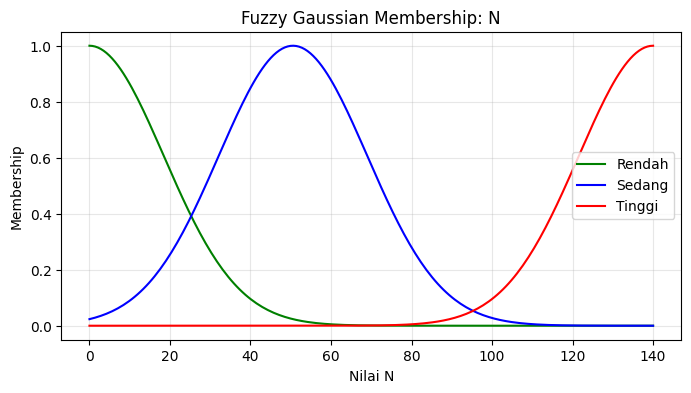

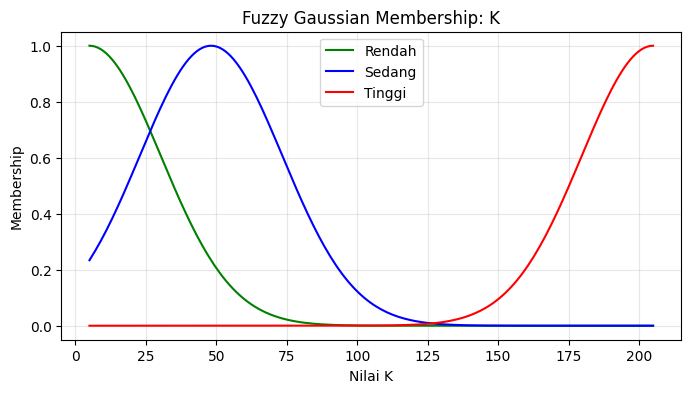

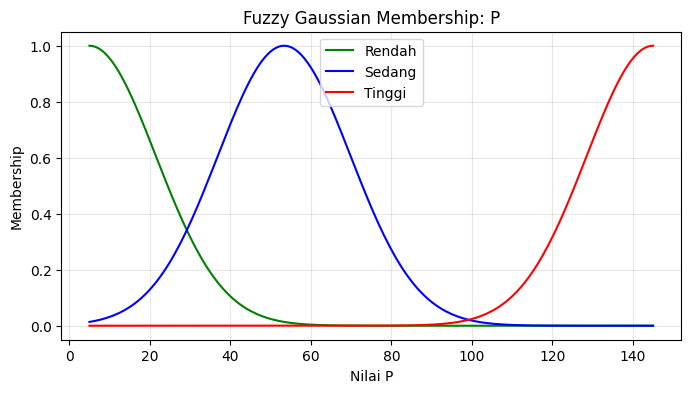

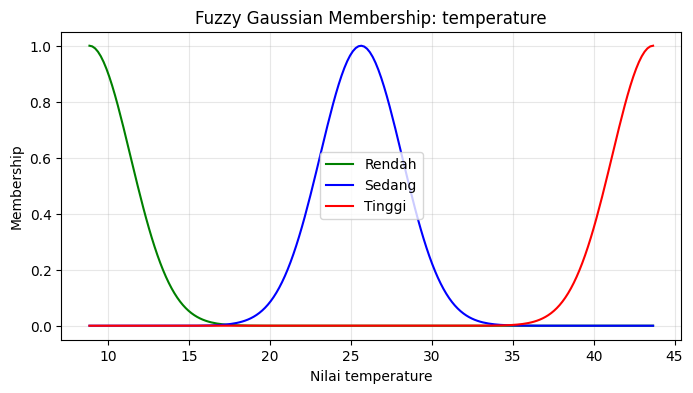

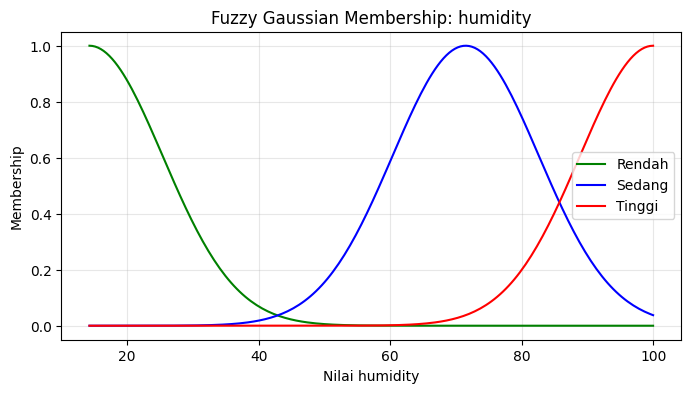

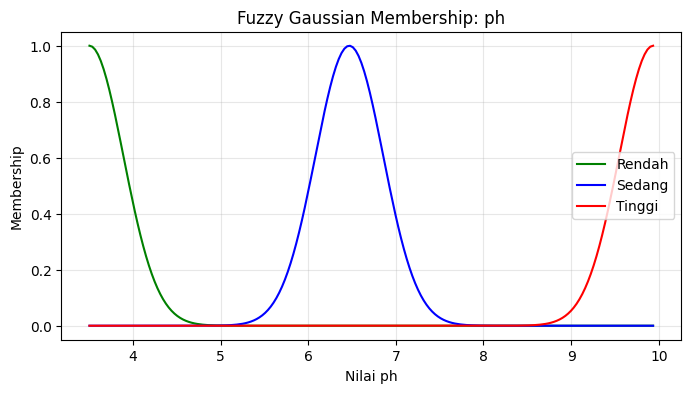

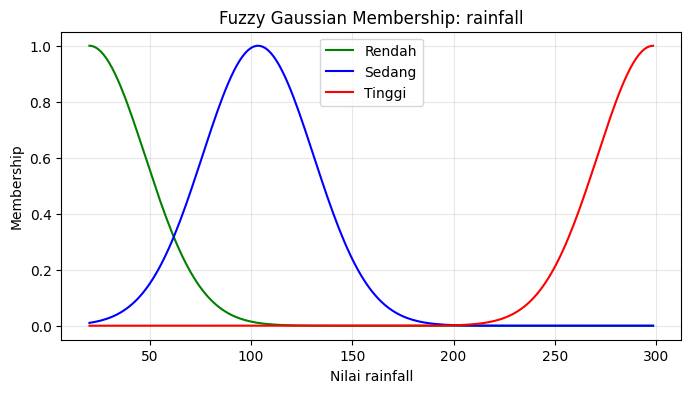

In [ ]:
# ==========================================
# BAGIAN 5: VISUALISASI MEMBERSHIP FUNCTION
# ==========================================

def plot_gaussian(col_name):
    data = df[col_name]
    mean = np.mean(data)
    sigma = np.std(data)
    d_min, d_max = data.min(), data.max()
    x = np.linspace(d_min, d_max, 200)

    # Generate Kurva
    low = fuzz.gaussmf(x, d_min, sigma/2)
    med = fuzz.gaussmf(x, mean, sigma/2)
    high = fuzz.gaussmf(x, d_max, sigma/2)

    plt.figure(figsize=(8, 4))
    plt.plot(x, low, 'g', label='Rendah')
    plt.plot(x, med, 'b', label='Sedang')
    plt.plot(x, high, 'r', label='Tinggi')
    plt.title(f'Fuzzy Gaussian Membership: {col_name}')
    plt.xlabel(f'Nilai {col_name}')
    plt.ylabel('Membership')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Tampilkan sampel (misal Rainfall dan Temperature)
plot_gaussian('N')
plot_gaussian('K')
plot_gaussian('P')
plot_gaussian('temperature')
plot_gaussian('humidity')
plot_gaussian('ph')
plot_gaussian('rainfall')

### **6. Demo Aplikasi (User Interface)**
Pada tahap akhir, fungsi ini mensimulasikan penggunaan sistem di dunia nyata. Pengguna dapat memasukkan nilai parameter tanah, dan sistem akan melakukan fuzzifikasi input tersebut lalu memprediksi tanaman yang paling cocok menggunakan model AI yang telah dilatih.

In [ ]:
# ==========================================
# BAGIAN 6: DEMO APLIKASI USER
# ==========================================

def prediksi_tanaman(n, p, k, temp, hum, ph, rain):
    print(f"\n🔎 Analisa: N={n}, P={p}, K={k}, Suhu={temp}, Hujan={rain}...")

    # 1. Siapkan Input
    input_dict = {'N':n, 'P':p, 'K':k, 'temperature':temp, 'humidity':hum, 'ph':ph, 'rainfall':rain}
    fuzzy_vector = []

    # 2. Proses Fuzzifikasi Input User (Sama persis dengan training)
    for col, val in input_dict.items():
        ref_data = df[col]
        mean = np.mean(ref_data)
        sigma = np.std(ref_data)
        d_min, d_max = ref_data.min(), ref_data.max()
        univ = np.linspace(d_min, d_max, 100)

        mf_l = fuzz.gaussmf(univ, d_min, sigma/2)
        mf_m = fuzz.gaussmf(univ, mean, sigma/2)
        mf_h = fuzz.gaussmf(univ, d_max, sigma/2)

        fuzzy_vector.extend([
            fuzz.interp_membership(univ, mf_l, val),
            fuzz.interp_membership(univ, mf_m, val),
            fuzz.interp_membership(univ, mf_h, val)
        ])

    # 3. Prediksi Neural Network
    hasil = clf_best.predict([fuzzy_vector])[0]

    print("="*40)
    print(f"🌱 REKOMENDASI AI: {hasil.upper()}")
    print("="*40)

# --- COBA INPUT MANUAL DI SINI ---
# Contoh Kasus: Tanah Lembab & Subur
prediksi_tanaman(n=90, p=58, k=40, temp=23, hum=83, ph=7, rain=226)

# Contoh Kasus: Tanah Kering & Panas
prediksi_tanaman(n=20, p=20, k=20, temp=35, hum=40, ph=6, rain=50)


🔎 Analisa: N=90, P=58, K=40, Suhu=23, Hujan=226...
🌱 REKOMENDASI AI: RICE

🔎 Analisa: N=20, P=20, K=20, Suhu=35, Hujan=50...
🌱 REKOMENDASI AI: MOTHBEANS
